# 1. Import libraries and load data 

In [3]:
# Import libraries
import pandas as pd
from collections import Counter
from ydata_profiling import ProfileReport
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

# Load dataset
df = pd.read_csv('data.csv')

# Build product metadata lookup, including sub-category and popularity
df_meta = df[['product_id', 'title_en', 'category_translated', 'sub_category_translated', 'brand_name', 'popularity_rank', 'is_discount', 'main_delivery_city']]
product_meta = df_meta.drop_duplicates('product_id').set_index('product_id')
product_ids = sorted(product_meta.index)

# 2. Create a data overview report


**What is it?**  
We use the `ydata_profiling` library to quickly generate a detailed report about the dataset. This includes summaries of each column (like missing values, unique counts, distributions) and insights into correlations and data quality issues.

**Why it’s useful:**  
This gives both technical and business users a full understanding of the data with minimal effort. You can find patterns, spot data quality problems, and understand what kind of information we have before building models.

**How to use the output:**  
Once the report is generated, scroll through the sections like "Overview", "Variables", and "Interactions". This helps you decide what cleaning or feature engineering steps might be needed.
"""

In [4]:
# Create report using ydata_profiling
profile = ProfileReport(df, title="Data Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 49.76it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 3. Customer clusters


**What happens in this section?**  
We will group customers into **segments (clusters)** based on their behavior and product preferences. Clustering lets us identify different types of users, such as bargain hunters, brand loyalists, or health-conscious shoppers.

**Why it matters for recommendations:**  
These clusters help us build more **personalized and effective recommendations**. Instead of treating every user the same, we tailor suggestions based on their segment, improving user satisfaction and sales conversion.

## Generate features for K-Means clustering

**Why go beyond just product_id and user_id?**  
To cluster users meaningfully, we need to describe their behavior and preferences with **numerical features** (e.g., number of purchases in a category, average spend, discount sensitivity).

**What’s the goal?**  
We're converting complex purchase patterns into numbers that a machine learning algorithm (K-Means) can use to group similar users.


In [5]:
# Calculate average purchase price per customer
avg_purchase_price = df.groupby(['customer_id', 'purchase_id'])['price'].sum().groupby('customer_id').mean()

# Calculate average number of products per basket per customer
avg_basket_product_number = df.groupby(['customer_id', 'purchase_id'])['product_id'].count().groupby('customer_id').mean()

# Build interaction matrix (users × products)
interaction = pd.crosstab(df['customer_id'], df['product_id']).reindex(columns=product_ids, fill_value=0)
table = (interaction > 0).astype(int)

# Create matrix with customer_id and product_id
customer_ids = sorted(set(table.index) & set(avg_purchase_price.index) & set(avg_basket_product_number.index))
table_with_price = table.loc[customer_ids]

# Scale features
avg_purchase_scaled = StandardScaler().fit_transform(avg_purchase_price.loc[customer_ids].values.reshape(-1, 1))
avg_basket_scaled = StandardScaler().fit_transform(avg_basket_product_number.loc[customer_ids].values.reshape(-1, 1))

# Create matrix for K-Means with customers, products and custom features
enhanced_data_matrix = np.hstack([table_with_price.values, avg_purchase_scaled, avg_basket_scaled])

## Identify the optimal amount of clusters

**Why this step matters:**  
We don’t want to guess how many user segments to create. Instead, we use metrics like **Silhouette Score** to find the number of clusters that gives us the most meaningful and separate groupings.

**How it works:**  
The score evaluates how similar users are within a cluster vs. other clusters. A higher score means better-defined segments.


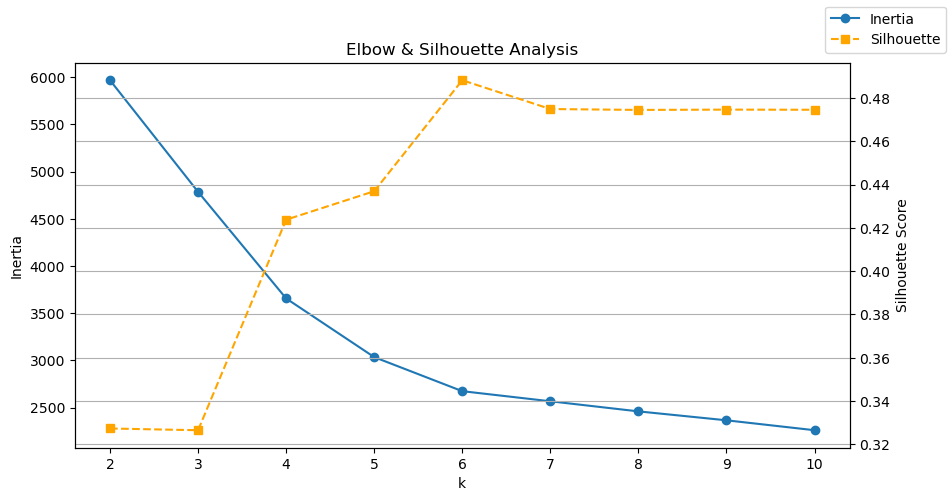


=== Optimal Cluster Selection ===
• Optimal k by Silhouette Score : 6 (score = 0.488)
• Optimal k by Elbow Heuristic  : 5
• Final k selected for clustering: 6

=== Cluster Membership ===
Number of customers in each cluster:
segment
0    15
1    15
2    15
3    15
4    15
5    15
Name: count, dtype: int64


In [6]:
# 3. User Segmentation & Optimal k Selection
ks = range(2, 11) # Number of clusters to try
inertias, silhouettes = [], []

# Loop over 10 times the algorithm with different initial centroids and keep the best one
#   Inertia measures compactness of clusters. The lower the better
#   Silhouette measures quality/separation of clusters. The higher the better
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(enhanced_data_matrix)
    inertias.append(km.inertia_)
    # silhouette_score shows how similar a user is to its own cluster vs. other clusters. From -1 to 1
    silhouettes.append(silhouette_score(enhanced_data_matrix, labels))

# Plot metrics
def plot_elbow_silhouette(ks, inertias, silhouettes):
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()
    ax1.plot(ks, inertias, 'o-', label='Inertia')
    ax2.plot(ks, silhouettes, 's--', color='orange', label='Silhouette')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia')
    ax2.set_ylabel('Silhouette Score')
    plt.title('Elbow & Silhouette Analysis')
    fig.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Plot elbow and silhouette
plot_elbow_silhouette(ks, inertias, silhouettes)

# Automatically select the silhouette number for clustering
k_sil = ks[np.argmax(silhouettes)]

# Elbow heuristic via second derivative
d1 = np.diff(inertias)
d2 = np.diff(d1)
k_elbow = ks[np.argmax(d2) + 2]

# Decide k (default to silhouette)
n_clusters = k_sil

# Fit K-Means with enhanced data
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
user_segments = pd.Series(kmeans.fit_predict(enhanced_data_matrix), index=customer_ids, name='segment')

print("\n=== Optimal Cluster Selection ===")
print(f"• Optimal k by Silhouette Score : {k_sil} (score = {max(silhouettes):.3f})")
print(f"• Optimal k by Elbow Heuristic  : {k_elbow}")
print(f"• Final k selected for clustering: {n_clusters}")

print("\n=== Cluster Membership ===")
print("Number of customers in each cluster:")
print(user_segments.value_counts().sort_index())

## Plot clusters 


**What does this chart show?**  
Imagine we had 50 different things describing a user — t-SNE compresses all that into a simple 2D map. Together, they help us ‘see’ the invisible patterns in user behavior. 
- **Component 1 (X-axis):** Represents one direction of user similarity  
- **Component 2 (Y-axis):** Represents another direction  
- Users that are close together behave similarly. Users far apart behave differently.

**Why this helps:**  
It lets us “see” hidden patterns in user behavior and check if our clusters make intuitive sense.

**How to interpret the results:**  
- Cluster separation: Are clusters clearly apart froim each other? If yes, that means that the clusters are easily differentiated
- Cluster compactness: Are clusters "tight" or spread out? Meaning, if most of the data points or "balls" within the clusters are close to each other, it is a good sign, each customer is closely related to the rest od the cluster.
- Cluster size: Are some clusters much bigger/smaller? If they are pretty balanced, then it's good. Otherwise we'd need to understand why (i.e. features) of the clusters
- Outliers: Are there any random points far from all clusters? If no visible outliers, that means that customers of each cluster are similar between them

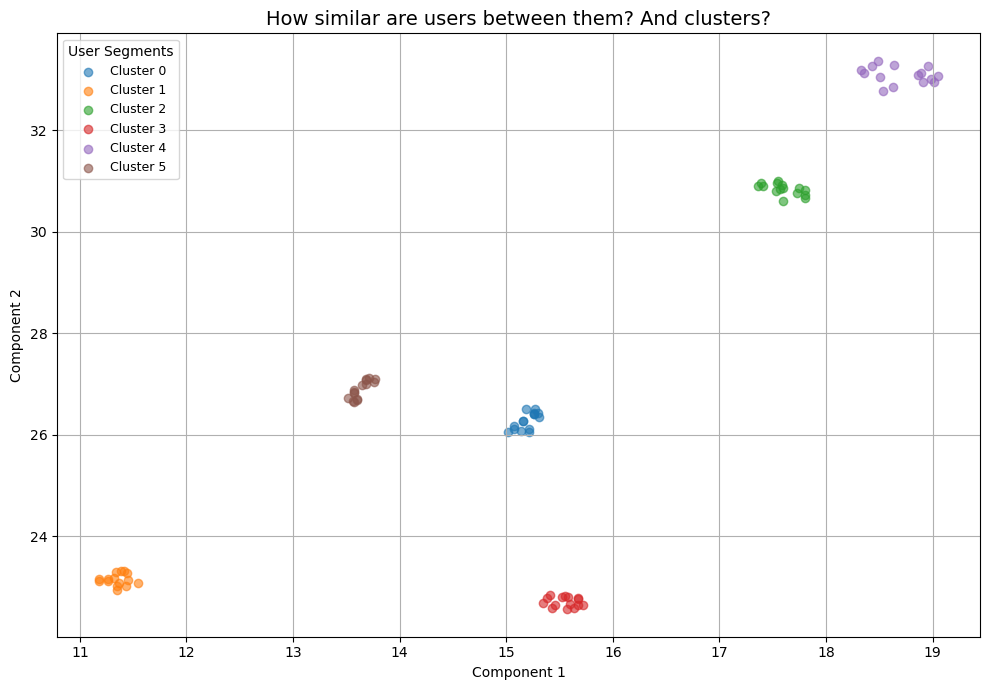

In [7]:
# Reduce dimensions with t-SNE. This is good for visualization of our previous clustering.

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_tsne = tsne.fit_transform(enhanced_data_matrix)

# Plot with custom legend
plt.figure(figsize=(10, 7))

# Scatter each cluster individually to add labels
for cluster_id in sorted(user_segments.unique()):
    indices = (user_segments == cluster_id)
    plt.scatter(
        reduced_tsne[indices, 0],
        reduced_tsne[indices, 1],
        label=f"Cluster {cluster_id}",
        alpha=0.6
    )

plt.title("How similar are users between them? And clusters?", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="User Segments", loc='best', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

## Create a report to understand our clusters


**What are we looking for here?**  
We analyze the characteristics of each customer cluster: what products they buy, which categories they prefer, how price-sensitive they are, etc.

**Why this is important:**  
This helps the business tailor marketing and product strategies to each group. For example, we might promote discounts more to the budget-conscious cluster.

In [8]:
# 1. Add user segment information to each transaction
df['segment'] = df['customer_id'].map(user_segments)
df_seg = df[df['segment'].notna()]  # Keep only valid segments

# 2. Basket Analysis: Avg products and spend per basket
products_per_basket = df_seg.groupby(['segment', 'purchase_id'])['product_id'].count()
avg_products_per_basket = products_per_basket.groupby('segment').mean().round(2)

purchase_totals = df_seg.groupby(['segment', 'purchase_id'])['price'].sum()
avg_purchase_price_by_segment = purchase_totals.groupby('segment').mean().round(2)

basket_stats_by_segment = pd.DataFrame({
    'Avg Products per Basket': avg_products_per_basket,
    'Avg Purchase Price': avg_purchase_price_by_segment
}).reset_index()

print("\n📦 Basket and Purchase Price by Segment:\n")
print(tabulate(basket_stats_by_segment, headers='keys', tablefmt='fancy_grid', showindex=False))

# 3. Top 5 Products per Segment
top_products_by_segment = (
    df_seg.groupby(['segment', 'title_en'])
    .size()
    .reset_index(name='count')
    .sort_values(['segment', 'count'], ascending=[True, False])
)
top_products = top_products_by_segment.groupby('segment').head(5)

print("\n🏆 Top 5 Products by Segment:\n")
for segment, group in top_products.groupby('segment'):
    print(f"Cluster {segment}:")
    print(tabulate(group[['title_en', 'count']], headers=["Product", "Count"], tablefmt='github', showindex=False))
    print()

# 4. Discount Usage by Segment
discount_usage = df_seg.groupby('segment')['is_discount'].mean().round(2).reset_index()
discount_usage.columns = ['Segment', 'Avg Discount Usage']

print("\n💸 Average Discount Usage by Segment:\n")
print(tabulate(discount_usage, headers='keys', tablefmt='fancy_grid', showindex=False))

# 5. Subcategory Diversity per Segment
subcategory_diversity = df_seg.groupby('segment')['sub_category_translated'].nunique().reset_index()
subcategory_diversity.columns = ['Segment', 'Unique Subcategories']

print("\n👪 Subcategory Diversity per Segment:\n") 
print(tabulate(subcategory_diversity, headers='keys', tablefmt='fancy_grid', showindex=False))



📦 Basket and Purchase Price by Segment:

╒═══════════╤═══════════════════════════╤══════════════════════╕
│   segment │   Avg Products per Basket │   Avg Purchase Price │
╞═══════════╪═══════════════════════════╪══════════════════════╡
│         0 │                        23 │                86.93 │
├───────────┼───────────────────────────┼──────────────────────┤
│         1 │                        19 │                35.84 │
├───────────┼───────────────────────────┼──────────────────────┤
│         2 │                        28 │                79.62 │
├───────────┼───────────────────────────┼──────────────────────┤
│         3 │                        20 │                21.58 │
├───────────┼───────────────────────────┼──────────────────────┤
│         4 │                        32 │               102.71 │
├───────────┼───────────────────────────┼──────────────────────┤
│         5 │                        26 │               150.3  │
╘═══════════╧═══════════════════════════╧═══════

# 4. Hybrid recommendation model 

**What is a hybrid model?**  
It combines two approaches:
- **Content-based filtering**: Recommends products similar to what the user liked before
- **Collaborative filtering**: Recommends what similar users liked

**Why this is powerful:**  
It balances the strengths of both systems. Content-based ensures relevance; collaborative finds new things users may not discover on their own. This improves both **accuracy** and **discovery**.


In [9]:
###########################################################################
###
###      Build product descriptions for content-based similarity
###
###########################################################################

# We're combining product name, sub-category and discount flag
# into one text field that describes the "essence" of the product.
product_features = product_meta[['title_en', 'category_translated', 'sub_category_translated', 'brand_name', 'is_discount']].copy()

# Clean and prepare features: fill blanks and convert to string
for col in ['title_en', 'brand_name', 'category_translated', 'sub_category_translated']:
    product_features[col] = product_features[col].fillna('').astype(str)
product_features['is_discount'] = product_features['is_discount'].fillna(0).astype(str)

# Merge into one text string per product for machine learning to process
product_features['features'] = (
    product_features['title_en'] + ' ' +
    product_features['sub_category_translated'] + ' ' +
    product_features['brand_name'] + ' ' +
    product_features['is_discount']
)


###########################################################################
###
###               Calculate Content-Based Similarity
###
###########################################################################

# TF-IDF (Term Frequency - Inverse Document Frequency) converts product descriptions into a numerical format.
# Words that are unique to a product are given more importance.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_features['features'])

# Cosine similarity: compares each product with every other product based on their text descriptions
# Cosine similarity = 1 means very similar, 0 means unrelated
content_sim = cosine_similarity(tfidf_matrix)

# Store results as a readable table (product vs product)
content_sim_df = pd.DataFrame(content_sim, index=product_meta.index, columns=product_meta.index)

# STEP 3: Calculate Collaborative Filtering Similarity
# Here we compare products based on user behavior (who bought what), using the item-user matrix.
# Two products are similar if bought by the same types of customers.
item_user_matrix = table_with_price.T
collab_sim = cosine_similarity(item_user_matrix)

# Store collaborative similarity results
collab_sim_df = pd.DataFrame(collab_sim, index=item_user_matrix.index, columns=item_user_matrix.index)


###########################################################################
###
###           Combine both approaches: Content + Collaborative
###
###########################################################################

# Hybrid similarity = 60% content-based + 40% collaborative filtering
# This captures both product characteristics and customer behavior
def hybrid_similarity(content_sim, collab_sim, alpha=0.6):
    return alpha * content_sim + (1 - alpha) * collab_sim

hybrid_sim = hybrid_similarity(content_sim, collab_sim, alpha=0.6) # alpha: % content-based
hybrid_sim_df = pd.DataFrame(hybrid_sim, index=product_meta.index, columns=product_meta.index)

# Optional helper to normalize any product similarity vector (for ranking)
def normalize(x):
    norm = np.linalg.norm(x)
    return x / norm if norm != 0 else x


# 5. Define recommendation engine for different scenarios

**Why go beyond just hybrid recommendations?**  
Users behave differently in different contexts — we adapt recommendations based on the situation: first-time visitor, loyal buyer, or someone with a full cart.

**What this section does:**  
We build **dynamic recommendation logic** for different scenarios. For example:
- Use segment-based suggestions for new users
- Personalize using collaborative scores for loyal users

**Business benefit:**  
Improves engagement by meeting users where they are in the buying journey, instead of using a one-size-fits-all model.


In [10]:
# Recommend top N products for a given segment using hybrid similarity
def recommend_for_segment(seg_idx, top_n=5, alpha=0.6, oversample=5):
    users = user_segments[user_segments == seg_idx].index
    seg_vec = table.loc[users].mean(axis=0).values  # average preferences of segment

    # Hybrid score: weighted average of content and collaborative filtering
    hybrid_scores = alpha * normalize(seg_vec @ content_sim) + (1 - alpha) * normalize(seg_vec @ collab_sim)
    idxs = np.argsort(hybrid_scores)[::-1][:top_n * oversample]  # Oversample for diversity
    candidate_ids = [product_ids[i] for i in idxs]

    # Promote diversity by selecting products from different subcategories
    diverse = []
    seen_sub = set()
    for pid in candidate_ids:
        sub = product_meta.loc[pid, 'sub_category_translated']
        if sub not in seen_sub:
            diverse.append(pid)
            seen_sub.add(sub)
        if len(diverse) >= top_n * 2:
            break

    # Sort final recommendations by popularity
    final_sorted = sorted(diverse[:top_n], key=lambda pid: product_meta.loc[pid, 'popularity_rank'])
    return [(pid, product_meta.loc[pid, 'title_en']) for pid in final_sorted]


# Recommend top N products for an individual user
def recommend_for_user(user_id, top_n=5, alpha=0.6, oversample=5):
    if user_id not in table.index:
        # Cold Start: If user has no previous purchase history, fallback to a default recommendation
        print(f"New user detected: {user_id}, recommending based on user segment or general popularity.")
        
        # Option 1: Fallback to segment-based recommendation for a new user (assuming segment is assigned)
        if user_id in user_segments:
            seg = user_segments[user_id]
            return recommend_for_segment(seg, top_n=top_n, alpha=alpha)
        
        # Option 2: If no segment available, fallback to the most popular products
        print("No segment found for new user, recommending based on overall popularity.")
        popular_products = product_meta.sort_values(by='popularity_rank', ascending=True).head(top_n)
        return [(pid, popular_products.loc[pid, 'title_en']) for pid in popular_products.index]

    # Regular recommendation for known users
    user_purchased = table.loc[user_id]
    purchased_ids = user_purchased[user_purchased > 0].index.tolist()

    # Extract user's preferred subcategories from past purchases
    user_subs = set(product_meta.loc[purchased_ids, 'sub_category_translated'].dropna())
    if not user_subs:
        user_subs = set(product_meta['sub_category_translated'])  # default to all if none

    # Recommend more items for the user's segment (oversampled to allow filtering)
    seg = user_segments[user_id]
    cands = [pid for pid, _ in recommend_for_segment(seg, top_n=top_n * oversample, alpha=alpha)]
    cands = [pid for pid in cands if pid not in purchased_ids]  # remove already purchased

    # Ensure diversity by selecting products from different subcategories
    diverse = []
    seen_sub = set()
    for pid in cands:
        sub = product_meta.loc[pid, 'sub_category_translated']
        if sub not in seen_sub:
            diverse.append(pid)
            seen_sub.add(sub)
        if len(diverse) >= top_n * 2:
            break

    # Score recommendations using hybrid similarity with the user's profile
    rec_idxs = [product_ids.index(pid) for pid in diverse]
    user_vec = table.loc[user_id].values
    scores = user_vec @ hybrid_sim[:, rec_idxs]
    top_local = np.argsort(scores)[::-1][:top_n]
    final = [diverse[i] for i in top_local]

    # Return final sorted list by product popularity
    final_sorted = sorted(final, key=lambda pid: product_meta.loc[pid, 'popularity_rank'])
    return [(pid, product_meta.loc[pid, 'title_en']) for pid in final_sorted]


# Recommend products based on the current shopping cart
def recommend_for_cart_and_user(cart_products, user_id=None, top_n=5, alpha=0.6, beta=0.5):
    cart_vec = np.zeros(len(product_ids))
    c_idxs = [product_ids.index(p) for p in cart_products if p in product_ids]
    cart_vec[c_idxs] = 1

    # Compute similarity scores based on cart
    cart_cf = cart_vec @ collab_sim
    cart_cb = cart_vec @ content_sim
    cart_hybrid = alpha * normalize(cart_cb) + (1 - alpha) * normalize(cart_cf)

    if user_id is not None and user_id in table.index:
        user_vec = table.loc[user_id].values
        user_hybrid = user_vec @ hybrid_sim
        hybrid = beta * normalize(cart_hybrid) + (1 - beta) * normalize(user_hybrid)
    else:
        # Cold Start: If user unknown, fallback to cart-only recommendations
        print(f"New user detected or no user info, recommending based on cart only.")
        hybrid = cart_hybrid

    # Rank candidates and remove items already in cart
    idxs = np.argsort(hybrid)[::-1]
    candidates = [product_ids[i] for i in idxs if product_ids[i] not in cart_products]

    # Promote diversity by recommending different subcategories
    diverse = []
    seen_sub = set()
    for pid in candidates:
        sub = product_meta.loc[pid, 'sub_category_translated']
        if sub not in seen_sub:
            diverse.append(pid)
            seen_sub.add(sub)
        if len(diverse) >= top_n * 2:
            break

    # Return top N recommendations sorted by popularity
    final_sorted = sorted(diverse[:top_n], key=lambda pid: product_meta.loc[pid, 'popularity_rank'])
    return [(pid, product_meta.loc[pid, 'title_en']) for pid in final_sorted]


# Test our different scenarios

**Why this is crucial:**
This is the final check. Testing different user types ensures our system responds appropriately and delivers quality recommendations across all cases.

In [11]:
# Test segment recommendation
segment_id = 4
segment_recommendations = recommend_for_segment(seg_idx=segment_id, top_n=10, alpha=0.6)

print(f"Personalized Recommendations for Segment: {segment_id}")
print("-------------------------------------------------")
for idx, (pid, title) in enumerate(segment_recommendations, 1):
    print(f"{idx}. Product ID: {pid} | Title: {title}")
print("\n")


# Test user recommendation
test_user = 'F7811111115'
user_recommendations = recommend_for_user(test_user, top_n=10, alpha=0.7)

print(f"Personalized Recommendations for User: {test_user}")
print("-------------------------------------------------")
for idx, (pid, title) in enumerate(user_recommendations, 1):
    print(f"{idx}. Product ID: {pid} | Title: {title}")
print("\n")


# Test cart-based recommendation
test_cart = [1177, 1031, 612]  # example product_ids
cart_recommendations = recommend_for_cart_and_user(test_cart, user_id='F7811111115', top_n=10, alpha=0.6, beta=0.5)

print(f"Recommendations Based on Cart: {test_cart}, for user 'F7811111115'")
print("-------------------------------------------------")
for idx, (pid, title) in enumerate(cart_recommendations, 1):
    print(f"{idx}. Product ID: {pid} | Title: {title}")
print("\n")
    

# Test user recommendation
test_user = '60176ce3-aa88-437a-9673-dd0262cdf560'
user_recommendations = recommend_for_user(test_user, top_n=10, alpha=0.7)

print(f"Personalized Recommendations for User: {test_user}")
print("-------------------------------------------------")
for idx, (pid, title) in enumerate(user_recommendations, 1):
    print(f"{idx}. Product ID: {pid} | Title: {title}")
print("\n")


# Test cart-based recommendation
test_cart = [1086, 468, 612]  # example product_ids
cart_recommendations = recommend_for_cart_and_user(test_cart, user_id='60176ce3-aa88-437a-9673-dd0262cdf560', top_n=10, alpha=0.6, beta=0.5)

print(f"Recommendations Based on Cart: {test_cart}")
print("-------------------------------------------------")
for idx, (pid, title) in enumerate(cart_recommendations, 1):
    print(f"{idx}. Product ID: {pid} | Title: {title}")

Personalized Recommendations for Segment: 4
-------------------------------------------------
1. Product ID: 600 | Title: Atlantic salmon fillet salted WELL DONE 100g
2. Product ID: 3 | Title: Eggs laid in the barn WELL DONE M size 10 pcs.
3. Product ID: 777 | Title: Nut-raisin mixture ARIMEX 500g
4. Product ID: 76 | Title: Milk UHT without lactose WELL DONE 1.5% 1L
5. Product ID: 692 | Title: Pasta LA MOLISANA Spaghetti No. 15 500g
6. Product ID: 152 | Title: Kefir FARM MILK 2% 1kg
7. Product ID: 1031 | Title: Orange juice WELL DONE 1L PET D
8. Product ID: 747 | Title: Cereal bar NESTLE NESQUIK 4 x 25g
9. Product ID: 50 | Title: Cereal curd FARM MILK 5% 500g
10. Product ID: 303 | Title: Cabbage pickled with cumin 800g


Personalized Recommendations for User: F7811111115
-------------------------------------------------
1. Product ID: 1177 | Title: Thick RÜDOLFS BIO garden buckwheat young 8+ 190g
2. Product ID: 128 | Title: ACTIMEL strawberry-blackberry-blueberry yogurt drink 12x100g
3

# Identify potential data drift

**Why this is crucial:**
The economic environment or user preferences can change, and therefore, we need to keep an eye on how well we recommend products to our customers. If the recommendations are not meaningful anymore, we are losing potential to increase our revenue and customer retention

In [12]:
###########################################################################
###
###               Create a random synthetic dataset
###
###########################################################################

def generate_random_dataframe(original_df, n_rows=1000):
    np.random.seed(42)  # for reproducibility
    
    def sample_column(col):
        if pd.api.types.is_numeric_dtype(original_df[col]):
            return np.random.choice(original_df[col].dropna().unique(), size=n_rows)
        else:
            return np.random.choice(original_df[col].dropna().unique(), size=n_rows)
    
    random_df = pd.DataFrame({
        'customer_id': sample_column('customer_id'),
        'purchase_id': np.random.randint(low=1, high=1_000_000, size=n_rows),  # simulate new purchases
        'product_id': sample_column('product_id'),
        'title_en': sample_column('title_en'),
        'price': np.round(np.random.normal(loc=original_df['price'].mean(), scale=original_df['price'].std(), size=n_rows), 2),
        'category_translated': sample_column('category_translated'),
        'sub_category_translated': sample_column('sub_category_translated'),
        'brand_name': sample_column('brand_name'),
        'popularity_rank': np.random.randint(1, 10, size=n_rows),  # assuming rank is between 1 and 10
        'is_discount': np.random.choice([0.0, 1.0], size=n_rows, p=[0.7, 0.3]),
        'main_delivery_city': sample_column('main_delivery_city'),
        'segment': sample_column('segment'),
    })

    return random_df

# Generate synthetic dataset
df_new = generate_random_dataframe(df, n_rows=500)
df_new.head()

,customer_id,purchase_id,product_id,title_en,price,category_translated,sub_category_translated,brand_name,popularity_rank,is_discount,main_delivery_city,segment
0,SI761997,108941,472,Herring rolls without skin KAIJA 480g,2.69,baby and children's goods,rice,LIELVĀRDES,5,0.0,Riga,1
1,S1515,824927,1233,Shower gel PALMOLIVE for children 750ml,6.82,bread and pastry products,special party,PĒTERGAILIS,7,0.0,Jurmala,1
2,C23456712,265518,661,Orange juice WELL DONE 1L PET D,-4.35,frozen party,porridge for children,Valmiera,4,0.0,Riga,0
3,C2345671,667522,76,Apples GRANNY SMITH kg,4.02,baby and children's goods,beer cider and cocktail,Forevers,7,0.0,Jelgava,0
4,ST4446,621821,30,Beer TÄRVETES SENCU light 4.5% 0.5L D,-0.69,bread and pastry products,beer cider and cocktail,JOHNIE WALKER,1,0.0,Riga,4


In [13]:
###########################################################################
###
###               Run Kolmogorov-Smirnov test
###
###########################################################################

# Safety check: ensure the new data isn't empty
if df_new.empty:
    print("No new data found for drift detection.")
else:
    # Calculate average purchase price per customer
    avg_purchase_price_new = df_new.groupby(['customer_id', 'purchase_id'])['price'].sum().groupby('customer_id').mean()

    # Calculate average number of products per basket per customer
    avg_basket_product_number_new = df_new.groupby(['customer_id', 'purchase_id'])['product_id'].count().groupby('customer_id').mean()

    # Build interaction matrix (users × products)
    interaction_new = pd.crosstab(df_new['customer_id'], df_new['product_id']).reindex(columns=product_ids, fill_value=0)
    table_new = (interaction_new > 0).astype(int)

    # Align customers and scale features
    customer_ids_new = sorted(set(table_new.index) & set(avg_purchase_price_new.index) & set(avg_basket_product_number_new.index))
    table_with_price_new = table_new.loc[customer_ids_new]

    # Apply same scaling as original
    avg_purchase_scaled_new = StandardScaler().fit_transform(avg_purchase_price_new.loc[customer_ids_new].values.reshape(-1, 1))
    avg_basket_scaled_new = StandardScaler().fit_transform(avg_basket_product_number_new.loc[customer_ids_new].values.reshape(-1, 1))

    # Create enhanced feature matrix
    new_data_matrix = np.hstack([table_with_price_new.values, avg_purchase_scaled_new, avg_basket_scaled_new])

    def compute_distances_to_centroids(data, model):
        """Compute distances to KMeans centroids"""
        distances = np.linalg.norm(data[:, None] - model.cluster_centers_, axis=2)
        return distances.min(axis=1)

    baseline_distances = compute_distances_to_centroids(enhanced_data_matrix, kmeans)
    new_distances = compute_distances_to_centroids(new_data_matrix, kmeans)

    # Run Kolmogorov-Smirnov test
    ks_stat, p_value = ks_2samp(baseline_distances, new_distances)

    print(f"KS Statistic: {ks_stat:.4f}")
    if ks_stat > 0.03:
        print("⚠️ Drift Detected: Significant change in distribution (KS statistic >= 0.5)")
    else:
        print("✅ No Drift Detected: Distributions are within expected range (KS statistic < 0.3)")

    print(f"P-Value: {p_value:.4f}")
    if p_value < 0.05:
        print("⚠️ Drift Detected: Significant change in distribution (p < 0.05)")
    else:
        print("✅ No Drift Detected: Distributions are similar (p >= 0.05)")

KS Statistic: 0.6667
⚠️ Drift Detected: Significant change in distribution (KS statistic >= 0.5)
P-Value: 0.0000
⚠️ Drift Detected: Significant change in distribution (p < 0.05)


In [14]:
###########################################################################
###
###               Run Adjusted Rand Index (ARI)
###
###########################################################################

# Set new and old matrixes for comparison
X_ref = enhanced_data_matrix
X_current = new_data_matrix

# Fit KMeans on the reference period
kmeans_ref = KMeans(n_clusters=5, random_state=42, n_init=10).fit(X_ref)
ref_labels = kmeans_ref.labels_

# Predict cluster labels on the current data using the same model
current_labels = kmeans_ref.predict(X_current)

# Re-cluster current data independently for comparison
kmeans_current = KMeans(n_clusters=5, random_state=42, n_init=10).fit(X_current)
alt_current_labels = kmeans_current.labels_

# Calculate ARI between reference clusters and current (re-clustered) ones
ari_score = adjusted_rand_score(current_labels, alt_current_labels)
print(f"Adjusted Rand Index (ARI) for Drift Monitoring: {ari_score:.4f}")

if ari_score < 0:
    print(f"❌ Severe Drift Detected: Clustering structures strongly disagree (ARI = {ari_score:.4f} < 0)")
elif ari_score < 0.3:
    print(f"⚠️ Drift Detected: Significant change in clustering structure (ARI = {ari_score:.4f} < 0.3)")
else:
    print(f"✅ No Drift Detected: Clustering structure is stable (ARI = {ari_score:.4f} ≥ 0.3)")

Adjusted Rand Index (ARI) for Drift Monitoring: 0.0000
⚠️ Drift Detected: Significant change in clustering structure (ARI = 0.0000 < 0.3)


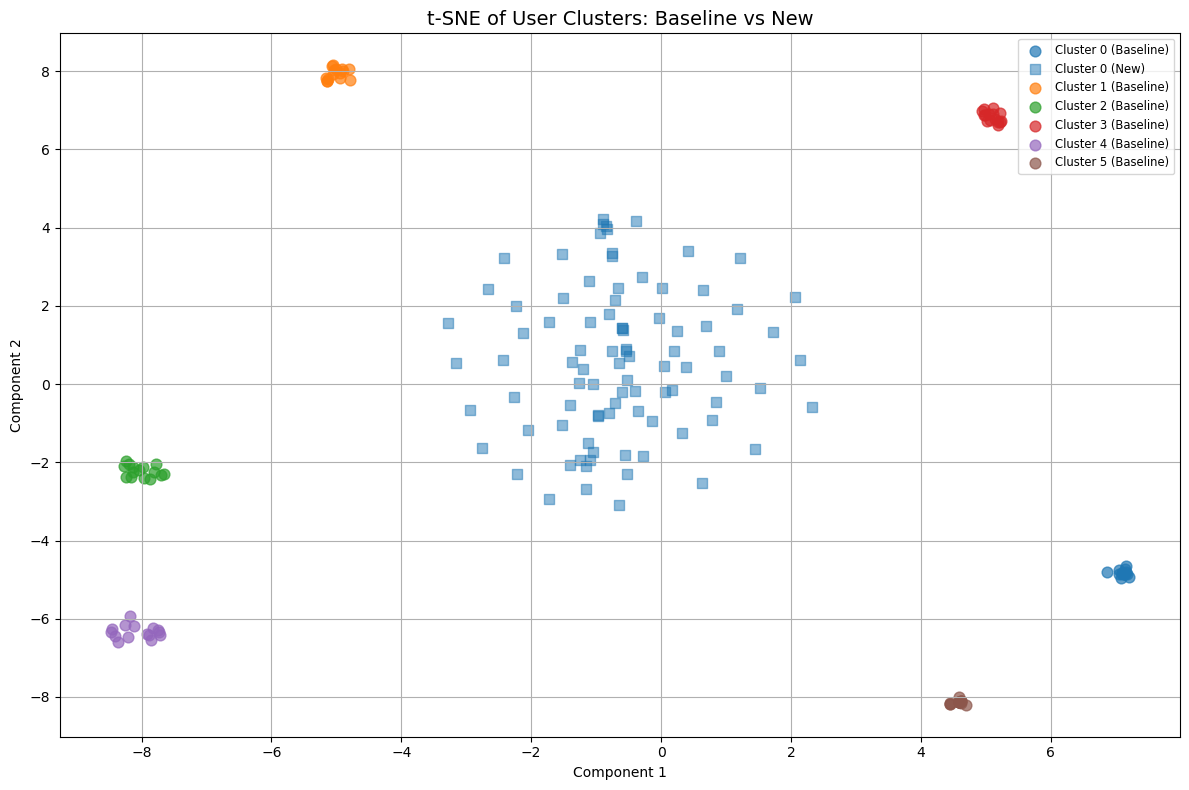

New user cluster counts: Counter({0: 90})
Old user cluster counts: Counter({2: 15, 4: 15, 1: 15, 5: 15, 3: 15, 0: 15})


In [15]:
###########################################################################
###
###               Visualise new clusters vs old ones
###
###########################################################################

new_labels = kmeans.predict(new_data_matrix)

# Combine data
combined_matrix = np.vstack([enhanced_data_matrix, new_data_matrix])
combined_cluster_labels = np.concatenate([kmeans.labels_, new_labels])
combined_data_labels = ['Baseline'] * len(enhanced_data_matrix) + ['New'] * len(new_data_matrix)

# t-SNE for 2D visualisation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(combined_matrix)

# Plotting clusters
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(combined_cluster_labels)

# Color map for consistency
colors = plt.cm.tab10.colors  # up to 10 clusters

for cluster in unique_clusters:
    # Get baseline users in this cluster
    idx_base = [i for i, (lbl, src) in enumerate(zip(combined_cluster_labels, combined_data_labels))
                if lbl == cluster and src == 'Baseline']
    if idx_base:
        plt.scatter(tsne_result[idx_base, 0], tsne_result[idx_base, 1],
                    label=f"Cluster {cluster} (Baseline)",
                    alpha=0.7, s=60, marker='o', color=colors[cluster % len(colors)])
    
    # Get new users in this cluster
    idx_new = [i for i, (lbl, src) in enumerate(zip(combined_cluster_labels, combined_data_labels))
               if lbl == cluster and src == 'New']
    if idx_new:
        plt.scatter(tsne_result[idx_new, 0], tsne_result[idx_new, 1],
                    label=f"Cluster {cluster} (New)",
                    alpha=0.5, s=60, marker='s', color=colors[cluster % len(colors)])

plt.title("t-SNE of User Clusters: Baseline vs New", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

print("New user cluster counts:", Counter(new_labels))
print("Old user cluster counts:", Counter(user_segments))
